In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from math import sqrt

from tqdm import tqdm

In [2]:
batch_size = 64
num_classes = 10
learning_rate = 10e-3
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 64, # TEST BATCH SIZE
                                           shuffle = False)

In [4]:
# MODEL DEFINITION FROM: https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [5]:
LeNet = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(LeNet.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [6]:
# LOAD FROM SAVED FILE
LeNet = torch.load('LeNet.pth')
# SET TO EVALUATION MODE
LeNet.eval()

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
def flatten_data(batched_data):
    b, _, d, _ = batched_data.shape
    return batched_data.view(b, 1, d*d)

def unflatten_data(flattened_data, d):
    b, _ = flattened_data.shape[:2]
    return flattened_data.view(b, 1, d, d)

In [8]:
def F_torch(x, y, model, queries = None):
    """
    Loss function for all the examples

    Input:
    - x: images [batch_size, channels, height, width]
    - y: true labels of the images [batch_size]
    - model: the PyTorch model used for prediction
    - queries - running total of model calls (optional)

    Returns:
    - Loss: computed loss
    """
    if queries != None:
        queries[0] += 1
    f = model(x)
    f_yi = torch.gather(f, 1, y.view(-1, 1)).squeeze()
    
    # mask correct class
    mask = torch.arange(f.size(1)).expand(f.size(0), f.size(1)).to(y.device)# (B, 10)
    mask = mask != y.view(-1, 1)
    # Use sentinel to prevent wrong classes from getting selected
    f_j = torch.where(mask, f, torch.tensor(-1e10).to(f.device)).max(dim=1).values
    # Compute the loss and apply the ReLU operation (hinge loss)
    loss = torch.relu(f_yi - f_j)
    
    return loss.mean() #avg across batch

def uniGE(x, y, q, delta, d, model, queries = None):
    """
    Estimates gradient by taking mean of first order approximations in q different directions

    Input:
    - x: image [batch_size, channels, height, width]
    - y: true labels of the images [batch_size]
    - q: number of samples for grad calculation
    - v: Step size
    - d: dimensionality of the image (typically, channels x height x width)
    - model: the PyTorch model used for prediction inside the F_torch function

    Returns:
    - Averaged gradient estimate
    """
    device = x.device  # Get the device of the input tensor (either CPU or CUDA)

    # Create a tensor with standard normal values for all q directions
    u = torch.randn((q, d, d), device=device)

    # Compute the F function value for the original point
    F_0 = F_torch(x, y, model, queries)
    
    g = 0
    for j in range(q):
        F_forward = F_torch(x + delta*u[j], y, model, queries)
        g = g + (F_forward - F_0)*u[j]
    grad = (d / (delta * q)) * g

    return grad



In [9]:
def e(i, d, device):
    """
    Orthogonal basis vector in PyTorch

    Input:
    - i: index
    - d: dimensions
    - device: the device (CPU or CUDA) to place the tensor on

    Returns:
    - PyTorch tensor of shape [1, d, d]
    """
    ei = torch.zeros(1, d, d, device=device)
    ei[0, i//d, i%d] = 1
    return ei

def cooGE(x, y_true, mu, d, model):
    """
    PyTorch version of the coordinate-wise gradient estimator.

    Input:
    - x: PyTorch tensor of the images of shape [batch_size, 1, d, d]
    - y_true: PyTorch tensor of the true labels of the images of shape [batch_size]
    - mu: smoothing parameter
    - d: dimensions of the image (typically height x width for a grayscale image)
    - model: PyTorch model for predictions inside the F_Par_torch function (or your appropriate loss function)

    Returns:
    - PyTorch tensor of the coordinate-wise gradient estimate
    """
    device = x.device  # Get the device of the input tensor (either CPU or CUDA)
    
    q = torch.zeros(d, d, device=device)  # Assuming d is the height x width of the image

    for j in range(d*d):
        F_plus = F_torch(x + mu * e(j, d,device).view(1, 1, d, d), y_true, model)
        F_minus = F_torch(x - mu * e(j, d,device).view(1, 1, d, d), y_true, model)
        diff = F_plus - F_minus
        q = q + diff * e(j, d, device)

    return q / (2 * mu)

In [10]:
from torch.utils.data import DataLoader

# Create an unbatched DataLoader
test_grabber = DataLoader(test_dataset, batch_size=1, shuffle=False)

def get_examples(n, c, test_loader):
    """
    Return x, x_ori, y.
    """
    x_lst = []
    y_lst = []
    
    for a, l in test_loader:
        if l.item() == c:
            x_lst.append(a)
            y_lst.append(l)
            
        if len(x_lst) == n:
            break

    x_ori = torch.stack(x_lst).view((n,1,32,32))
    y = torch.stack(y_lst)
    x = x_ori.clone()
    return x, x_ori, y

In [11]:
def ZOFW(T, d, s, q, x, y, model, GE_step=-1, alpha=-1, B=1):
    device = x.device 

    if GE_step == -1:
        GE_step = sqrt(2 / (T * (d + 3)**3))
    if alpha == -1:
        alpha = 1 / torch.sqrt(torch.tensor(T, dtype=torch.float32))
    queries = [0]
    query_hist = []
    x_ori = x.clone()
    loss_hist = []
    perb = []
    loss_hist.append(F_torch(x, y, model).item())
    print("E:", 0, "Loss:", F_torch(x_ori, y, model, queries).item(), "Dist:", torch.max(torch.abs(x - x_ori)).item(), "Queries:", queries[0])
    for t in range(T):
        v_t = 0
        for i in tqdm(range(x.shape[0])):
            v_t += uniGE(x[i:i+1], y[i:i+1], q, GE_step, 32, model, queries)

        v_t = (1 / x.shape[0]) * v_t

        x_t = -s * torch.sign(v_t) + x_ori 
        x = (1 - alpha) * x + alpha * x_t
        perb.append(x)
        loss_hist.append(F_torch(x, y, model).item())
        print("E:", t+1, "Loss:", loss_hist[t], "Dist:", torch.max(torch.abs(x - x_ori)).item(), "Queries:", queries[0])
    query_hist.append(queries)
    print(f"End Loss:{loss_hist[-1]}")
    return loss_hist, perb, query_hist


In [13]:
T = 100 # EPOCHS
n = 100 # number of examples to attack
d = 32*32 # dimension
q = 30 # number of times to sample gradient
 # samples to run on [b,1,d] NOTE: this is flattened
x, _, y_true = get_examples(n, 4,test_grabber)
s = 0.1 # step size
loss_ZOFW, x_ZOFW, query_hist_ZOFW = ZOFW(T, d, s, q, x, y_true, LeNet)

E: 0 Loss: 12.895155906677246 Dist: 0.0 Queries: 1


100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


E: 1 Loss: 12.895155906677246 Dist: 0.010000228881835938 Queries: 3101


100%|██████████| 100/100 [00:09<00:00, 10.59it/s]


E: 2 Loss: 12.675017356872559 Dist: 0.01900029182434082 Queries: 6201


100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


E: 3 Loss: 12.479622840881348 Dist: 0.027100324630737305 Queries: 9301


100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


E: 4 Loss: 12.281079292297363 Dist: 0.03439044952392578 Queries: 12401


100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


E: 5 Loss: 12.103567123413086 Dist: 0.04095149040222168 Queries: 15501


100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


E: 6 Loss: 11.968750953674316 Dist: 0.04685640335083008 Queries: 18601


100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


E: 7 Loss: 11.805353164672852 Dist: 0.05217099189758301 Queries: 21701


100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


E: 8 Loss: 11.676758766174316 Dist: 0.056954145431518555 Queries: 24801


100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


E: 9 Loss: 11.537544250488281 Dist: 0.061258792877197266 Queries: 27901


100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


E: 10 Loss: 11.412997245788574 Dist: 0.06513309478759766 Queries: 31001


100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


E: 11 Loss: 11.319640159606934 Dist: 0.06861996650695801 Queries: 34101


100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


E: 12 Loss: 11.230419158935547 Dist: 0.07175803184509277 Queries: 37201


100%|██████████| 100/100 [00:08<00:00, 11.12it/s]


E: 13 Loss: 11.156424522399902 Dist: 0.07458233833312988 Queries: 40301


100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


E: 14 Loss: 11.090519905090332 Dist: 0.07712435722351074 Queries: 43401


100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


E: 15 Loss: 11.027496337890625 Dist: 0.07941198348999023 Queries: 46501


100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


E: 16 Loss: 10.964570045471191 Dist: 0.08147096633911133 Queries: 49601


100%|██████████| 100/100 [00:08<00:00, 12.49it/s]


E: 17 Loss: 10.930072784423828 Dist: 0.08332395553588867 Queries: 52701


100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


E: 18 Loss: 10.873865127563477 Dist: 0.0849916934967041 Queries: 55801


100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


E: 19 Loss: 10.836993217468262 Dist: 0.08649277687072754 Queries: 58901


100%|██████████| 100/100 [00:08<00:00, 12.25it/s]


E: 20 Loss: 10.794249534606934 Dist: 0.08784365653991699 Queries: 62001


100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


E: 21 Loss: 10.75053596496582 Dist: 0.08905935287475586 Queries: 65101


100%|██████████| 100/100 [00:08<00:00, 12.43it/s]


E: 22 Loss: 10.717120170593262 Dist: 0.09015345573425293 Queries: 68201


100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


E: 23 Loss: 10.671860694885254 Dist: 0.09113836288452148 Queries: 71301


100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


E: 24 Loss: 10.654385566711426 Dist: 0.09202456474304199 Queries: 74401


100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


E: 25 Loss: 10.635416030883789 Dist: 0.09282231330871582 Queries: 77501


100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


E: 26 Loss: 10.613363265991211 Dist: 0.09354019165039062 Queries: 80601


100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


E: 27 Loss: 10.60051155090332 Dist: 0.09418630599975586 Queries: 83701


100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


E: 28 Loss: 10.57708740234375 Dist: 0.09476780891418457 Queries: 86801


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


E: 29 Loss: 10.563190460205078 Dist: 0.0952911376953125 Queries: 89901


100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


E: 30 Loss: 10.544672966003418 Dist: 0.09576225280761719 Queries: 93001


100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


E: 31 Loss: 10.54762077331543 Dist: 0.09618616104125977 Queries: 96101


100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


E: 32 Loss: 10.518450736999512 Dist: 0.09656763076782227 Queries: 99201


100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


E: 33 Loss: 10.480511665344238 Dist: 0.09691095352172852 Queries: 102301


100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


E: 34 Loss: 10.458595275878906 Dist: 0.09721994400024414 Queries: 105401


100%|██████████| 100/100 [00:08<00:00, 12.48it/s]


E: 35 Loss: 10.442675590515137 Dist: 0.09749817848205566 Queries: 108501


100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


E: 36 Loss: 10.416609764099121 Dist: 0.0977485179901123 Queries: 111601


100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


E: 37 Loss: 10.382340431213379 Dist: 0.09797382354736328 Queries: 114701


100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


E: 38 Loss: 10.392739295959473 Dist: 0.09817647933959961 Queries: 117801


100%|██████████| 100/100 [00:08<00:00, 12.23it/s]


E: 39 Loss: 10.384432792663574 Dist: 0.0983588695526123 Queries: 120901


100%|██████████| 100/100 [00:08<00:00, 12.48it/s]


E: 40 Loss: 10.394478797912598 Dist: 0.09852313995361328 Queries: 124001


100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


E: 41 Loss: 10.387892723083496 Dist: 0.09867095947265625 Queries: 127101


100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


E: 42 Loss: 10.368494033813477 Dist: 0.09880399703979492 Queries: 130201


100%|██████████| 100/100 [00:07<00:00, 12.62it/s]


E: 43 Loss: 10.353445053100586 Dist: 0.0989236831665039 Queries: 133301


100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


E: 44 Loss: 10.344172477722168 Dist: 0.09903144836425781 Queries: 136401


100%|██████████| 100/100 [00:08<00:00, 12.43it/s]


E: 45 Loss: 10.364397048950195 Dist: 0.09912848472595215 Queries: 139501


100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


E: 46 Loss: 10.371320724487305 Dist: 0.09921574592590332 Queries: 142601


100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


E: 47 Loss: 10.368246078491211 Dist: 0.09929442405700684 Queries: 145701


100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


E: 48 Loss: 10.361928939819336 Dist: 0.099365234375 Queries: 148801


100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


E: 49 Loss: 10.332121849060059 Dist: 0.09942889213562012 Queries: 151901


100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


E: 50 Loss: 10.322714805603027 Dist: 0.09948611259460449 Queries: 155001


100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


E: 51 Loss: 10.302844047546387 Dist: 0.09953761100769043 Queries: 158101


100%|██████████| 100/100 [00:08<00:00, 12.34it/s]


E: 52 Loss: 10.295906066894531 Dist: 0.09958362579345703 Queries: 161201


100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


E: 53 Loss: 10.293461799621582 Dist: 0.0996253490447998 Queries: 164301


100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


E: 54 Loss: 10.295183181762695 Dist: 0.09966301918029785 Queries: 167401


100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


E: 55 Loss: 10.311834335327148 Dist: 0.09969615936279297 Queries: 170501


100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


E: 56 Loss: 10.313094139099121 Dist: 0.09972667694091797 Queries: 173601


100%|██████████| 100/100 [00:08<00:00, 12.43it/s]


E: 57 Loss: 10.307538986206055 Dist: 0.09975409507751465 Queries: 176701


100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


E: 58 Loss: 10.297222137451172 Dist: 0.09977865219116211 Queries: 179801


100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


E: 59 Loss: 10.280793190002441 Dist: 0.09980082511901855 Queries: 182901


100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


E: 60 Loss: 10.277935981750488 Dist: 0.09982085227966309 Queries: 186001


100%|██████████| 100/100 [00:08<00:00, 12.49it/s]


E: 61 Loss: 10.269603729248047 Dist: 0.0998387336730957 Queries: 189101


100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


E: 62 Loss: 10.268999099731445 Dist: 0.09985494613647461 Queries: 192201


100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


E: 63 Loss: 10.257040977478027 Dist: 0.0998694896697998 Queries: 195301


100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


E: 64 Loss: 10.249429702758789 Dist: 0.09988260269165039 Queries: 198401


100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


E: 65 Loss: 10.256481170654297 Dist: 0.09989428520202637 Queries: 201501


100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


E: 66 Loss: 10.24829387664795 Dist: 0.09990477561950684 Queries: 204601


100%|██████████| 100/100 [00:08<00:00, 12.25it/s]


E: 67 Loss: 10.222023010253906 Dist: 0.0999143123626709 Queries: 207701


100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


E: 68 Loss: 10.204158782958984 Dist: 0.09992289543151855 Queries: 210801


100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


E: 69 Loss: 10.18960189819336 Dist: 0.09993064403533936 Queries: 213901


100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


E: 70 Loss: 10.188606262207031 Dist: 0.0999375581741333 Queries: 217001


100%|██████████| 100/100 [00:08<00:00, 12.20it/s]


E: 71 Loss: 10.20970344543457 Dist: 0.09994387626647949 Queries: 220101


100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


E: 72 Loss: 10.210298538208008 Dist: 0.09994947910308838 Queries: 223201


100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


E: 73 Loss: 10.191149711608887 Dist: 0.09995460510253906 Queries: 226301


100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


E: 74 Loss: 10.219707489013672 Dist: 0.09995913505554199 Queries: 229401


100%|██████████| 100/100 [00:08<00:00, 12.40it/s]


E: 75 Loss: 10.199764251708984 Dist: 0.09996318817138672 Queries: 232501


100%|██████████| 100/100 [00:08<00:00, 12.21it/s]


E: 76 Loss: 10.210957527160645 Dist: 0.09996688365936279 Queries: 235601


100%|██████████| 100/100 [00:08<00:00, 12.22it/s]


E: 77 Loss: 10.220172882080078 Dist: 0.09997022151947021 Queries: 238701


100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


E: 78 Loss: 10.198092460632324 Dist: 0.09997320175170898 Queries: 241801


100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


E: 79 Loss: 10.206121444702148 Dist: 0.09997594356536865 Queries: 244901


100%|██████████| 100/100 [00:08<00:00, 12.30it/s]


E: 80 Loss: 10.197575569152832 Dist: 0.09997832775115967 Queries: 248001


100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


E: 81 Loss: 10.196863174438477 Dist: 0.09998047351837158 Queries: 251101


100%|██████████| 100/100 [00:08<00:00, 12.42it/s]


E: 82 Loss: 10.18481159210205 Dist: 0.09998250007629395 Queries: 254201


100%|██████████| 100/100 [00:08<00:00, 12.25it/s]


E: 83 Loss: 10.191301345825195 Dist: 0.09998428821563721 Queries: 257301


100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


E: 84 Loss: 10.185662269592285 Dist: 0.09998583793640137 Queries: 260401


100%|██████████| 100/100 [00:08<00:00, 12.10it/s]


E: 85 Loss: 10.209938049316406 Dist: 0.09998726844787598 Queries: 263501


100%|██████████| 100/100 [00:08<00:00, 12.43it/s]


E: 86 Loss: 10.248961448669434 Dist: 0.09998857975006104 Queries: 266601


100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


E: 87 Loss: 10.286901473999023 Dist: 0.09998977184295654 Queries: 269701


100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


E: 88 Loss: 10.265485763549805 Dist: 0.0999908447265625 Queries: 272801


100%|██████████| 100/100 [00:08<00:00, 12.30it/s]


E: 89 Loss: 10.248922348022461 Dist: 0.0999917984008789 Queries: 275901


100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


E: 90 Loss: 10.246731758117676 Dist: 0.09999263286590576 Queries: 279001


100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


E: 91 Loss: 10.269311904907227 Dist: 0.09999334812164307 Queries: 282101


100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


E: 92 Loss: 10.259860038757324 Dist: 0.09999406337738037 Queries: 285201


100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


E: 93 Loss: 10.272871971130371 Dist: 0.09999465942382812 Queries: 288301


100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


E: 94 Loss: 10.258081436157227 Dist: 0.09999525547027588 Queries: 291401


100%|██████████| 100/100 [00:08<00:00, 12.36it/s]


E: 95 Loss: 10.272655487060547 Dist: 0.09999573230743408 Queries: 294501


100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


E: 96 Loss: 10.265730857849121 Dist: 0.09999620914459229 Queries: 297601


100%|██████████| 100/100 [00:08<00:00, 12.34it/s]


E: 97 Loss: 10.256540298461914 Dist: 0.09999656677246094 Queries: 300701


100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


E: 98 Loss: 10.261448860168457 Dist: 0.09999704360961914 Queries: 303801


100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


E: 99 Loss: 10.270817756652832 Dist: 0.09999728202819824 Queries: 306901


100%|██████████| 100/100 [00:08<00:00, 11.81it/s]

E: 100 Loss: 10.25755500793457 Dist: 0.09999752044677734 Queries: 310001
End Loss:10.235568046569824


In [14]:
np.savetxt('FWBLACK.csv', np.array(loss_ZOFW), delimiter=",")

(-0.5, 31.5, 31.5, -0.5)

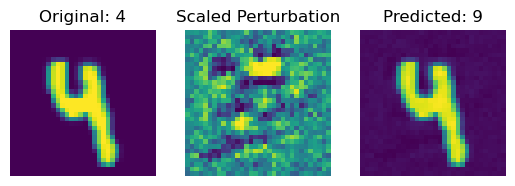

In [14]:
idx = -2
predicted = torch.argmax(LeNet(x_ZOFW[-1][idx].view((1,1,32,32)))).item()
fig, axs = plt.subplots(1,3)
axs[0].imshow(x[idx].squeeze().detach().numpy())
axs[0].set_title(f'Original: {y_true[idx].item()}')
axs[0].axis('off')
axs[1].imshow(x_ZOFW[-1][idx].squeeze().detach().numpy() - x[idx].squeeze().detach().numpy())
axs[1].set_title('Scaled Perturbation')
axs[1].axis('off')
axs[2].imshow(x_ZOFW[-1][idx].squeeze().detach().numpy())
axs[2].set_title(f'Predicted: {predicted}')
axs[2].axis('off')
#LeNet(x_ZOFW[idx].view((1,1,32,32)))

In [12]:
def ACC_ZOFW_uni(T,d,n,s,gamma, mu, x, y_true, model):
  # b1, b2 with b1 > b2
  # T, int: number of epoch

  b1 = n
  q = b2 = int(sqrt(n))
  if gamma == -1:
    gamma = 1/sqrt(T)
  if mu == -1:
    mu = 1/sqrt(d*T)
  
  v = sqrt(2 / (T * (d + 3)**3))
  q = 30
  
  x0 = x.clone()


  loss_ACC = []
  perturbations=[]
  queries = [0]
  query_hist = []
  # get base Loss
  loss_ACC.append(F_torch(x0, y_true, model).item())
  print("Itr:", 0, "Loss:", F_torch(x0, y_true, model), "Dist:", torch.max(torch.abs(x-x0)))

  for t in range(T):

    if (t % q == 0):
      # CASE 1: GRADIENT ESTIMATION WITH LARGER NUMBER OF SAMPLES
      # b1 > b2

      v_t = 0
      for i in tqdm(range(b1)):
        v_t = v_t + uniGE(x[i:i+1], y_true[i:i+1], q, v, 32, model, queries)
      v_t = v_t / b1
      v_t_1 = v_t

    else:
      # CASE 2: FAST GRADIENT ESTIMATION WITH b2 < b1

      v_t = 0
      b2_idx = np.random.randint(0, n, b2)

      for idx in tqdm(b2_idx,):
        v_t = v_t + uniGE(x[idx:idx+1], y_true[idx:idx+1], q, v, 32, model,queries) - uniGE(x_t_1[idx:idx+1], y_true[idx:idx+1], q, v, 32, model, queries) + v_t_1
      v_t = (1/b2) * v_t
      v_t_1 = v_t


    x_t_1 = x.clone()
    # LMO STEP
    u_t = -s * torch.sign(v_t) + x0
    d_t = u_t - x
    x = x + gamma*d_t

    perturbations.append(x)
    loss_ACC.append(F_torch(x, y_true, model).item())
    q
    print("E:", t+1, "Loss:", loss_ACC[t], "Dist:", torch.max(torch.abs(x-x0)).item(), "Queries:", queries[0])
    query_hist.append(queries[0])


  ACC_perb = x

  print("FZCGS Final loss = ", loss_ACC[-1])

  return loss_ACC, ACC_perb, query_hist

In [14]:
T = 100
d = 32*32
n = 100
s = 0.1
gamma = -1
mu = -1
x, _, y_true = get_examples(n, 4,test_grabber)
loss_ACC, x_ACC, query_hist_ACC = ACC_ZOFW_uni(T, d, n, s, gamma, mu, x, y_true, LeNet)

Itr: 0 Loss: tensor(12.8952, grad_fn=<MeanBackward0>) Dist: tensor(0.)


100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


E: 1 Loss: 12.895155906677246 Dist: 0.010000109672546387 Queries: 3100


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


E: 2 Loss: 12.672219276428223 Dist: 0.01900017261505127 Queries: 3720


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


E: 3 Loss: 12.616832733154297 Dist: 0.027100205421447754 Queries: 4340


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


E: 4 Loss: 12.58520221710205 Dist: 0.03439009189605713 Queries: 4960


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


E: 5 Loss: 12.545766830444336 Dist: 0.04095113277435303 Queries: 5580


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


E: 6 Loss: 12.51134967803955 Dist: 0.046856045722961426 Queries: 6200


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


E: 7 Loss: 12.478642463684082 Dist: 0.05217045545578003 Queries: 6820


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


E: 8 Loss: 12.447492599487305 Dist: 0.05695343017578125 Queries: 7440


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


E: 9 Loss: 12.434494972229004 Dist: 0.06125807762145996 Queries: 8060


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


E: 10 Loss: 12.426216125488281 Dist: 0.0651322603225708 Queries: 8680


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


E: 11 Loss: 12.3976411819458 Dist: 0.06861913204193115 Queries: 9300


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


E: 12 Loss: 12.359384536743164 Dist: 0.07175719738006592 Queries: 9920


100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


E: 13 Loss: 12.341409683227539 Dist: 0.07458150386810303 Queries: 10540


100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


E: 14 Loss: 12.32138442993164 Dist: 0.07712328433990479 Queries: 11160


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


E: 15 Loss: 12.306340217590332 Dist: 0.07941097021102905 Queries: 11780


100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


E: 16 Loss: 12.295327186584473 Dist: 0.08146989345550537 Queries: 12400


100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


E: 17 Loss: 12.300065040588379 Dist: 0.08332288265228271 Queries: 13020


100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


E: 18 Loss: 12.299938201904297 Dist: 0.08499062061309814 Queries: 13640


100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


E: 19 Loss: 12.289463996887207 Dist: 0.08649158477783203 Queries: 14260


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


E: 20 Loss: 12.28527545928955 Dist: 0.08784240484237671 Queries: 14880


100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


E: 21 Loss: 12.271671295166016 Dist: 0.08905816078186035 Queries: 15500


100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


E: 22 Loss: 12.269824028015137 Dist: 0.09015238285064697 Queries: 16120


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


E: 23 Loss: 12.271642684936523 Dist: 0.09113717079162598 Queries: 16740


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


E: 24 Loss: 12.267668724060059 Dist: 0.09202349185943604 Queries: 17360


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


E: 25 Loss: 12.257776260375977 Dist: 0.09282112121582031 Queries: 17980


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


E: 26 Loss: 12.247492790222168 Dist: 0.09353899955749512 Queries: 18600


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


E: 27 Loss: 12.240684509277344 Dist: 0.09418511390686035 Queries: 19220


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


E: 28 Loss: 12.224557876586914 Dist: 0.09476661682128906 Queries: 19840


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


E: 29 Loss: 12.215984344482422 Dist: 0.09528994560241699 Queries: 20460


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


E: 30 Loss: 12.188955307006836 Dist: 0.09576094150543213 Queries: 21080


100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


E: 31 Loss: 12.162616729736328 Dist: 0.09618484973907471 Queries: 24180


100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


E: 32 Loss: 11.999384880065918 Dist: 0.0965663492679596 Queries: 24800


100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


E: 33 Loss: 11.979774475097656 Dist: 0.09690971672534943 Queries: 25420


100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


E: 34 Loss: 11.975686073303223 Dist: 0.09721875190734863 Queries: 26040


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


E: 35 Loss: 11.989278793334961 Dist: 0.0974968671798706 Queries: 26660


100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


E: 36 Loss: 12.032129287719727 Dist: 0.09774720668792725 Queries: 27280


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


E: 37 Loss: 12.06825065612793 Dist: 0.09797251224517822 Queries: 27900


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


E: 38 Loss: 12.096833229064941 Dist: 0.0981752872467041 Queries: 28520


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


E: 39 Loss: 12.127886772155762 Dist: 0.09835773706436157 Queries: 29140


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


E: 40 Loss: 12.167377471923828 Dist: 0.09852194786071777 Queries: 29760


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


E: 41 Loss: 12.195714950561523 Dist: 0.09866976737976074 Queries: 30380


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


E: 42 Loss: 12.197076797485352 Dist: 0.09880280494689941 Queries: 31000


100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


E: 43 Loss: 12.211496353149414 Dist: 0.09892255067825317 Queries: 31620


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


E: 44 Loss: 12.218104362487793 Dist: 0.09903031587600708 Queries: 32240


100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


E: 45 Loss: 12.215178489685059 Dist: 0.09912729263305664 Queries: 32860


100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


E: 46 Loss: 12.2164888381958 Dist: 0.09921455383300781 Queries: 33480


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


E: 47 Loss: 12.213117599487305 Dist: 0.09929311275482178 Queries: 34100


100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


E: 48 Loss: 12.209674835205078 Dist: 0.09936380386352539 Queries: 34720


100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


E: 49 Loss: 12.22625732421875 Dist: 0.09942746162414551 Queries: 35340


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


E: 50 Loss: 12.234236717224121 Dist: 0.09948468208312988 Queries: 35960


100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


E: 51 Loss: 12.239252090454102 Dist: 0.0995362401008606 Queries: 36580


100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


E: 52 Loss: 12.267219543457031 Dist: 0.09958261251449585 Queries: 37200


100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


E: 53 Loss: 12.291838645935059 Dist: 0.09962433576583862 Queries: 37820


100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


E: 54 Loss: 12.320823669433594 Dist: 0.0996619462966919 Queries: 38440


100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


E: 55 Loss: 12.351531028747559 Dist: 0.09969580173492432 Queries: 39060


100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


E: 56 Loss: 12.364623069763184 Dist: 0.09972631931304932 Queries: 39680


100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


E: 57 Loss: 12.3898344039917 Dist: 0.099753737449646 Queries: 40300


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


E: 58 Loss: 12.416622161865234 Dist: 0.09977829456329346 Queries: 40920


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


E: 59 Loss: 12.439091682434082 Dist: 0.0998004674911499 Queries: 41540


100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


E: 60 Loss: 12.450278282165527 Dist: 0.09982049465179443 Queries: 42160


100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


E: 61 Loss: 12.469632148742676 Dist: 0.09983837604522705 Queries: 45260


100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


E: 62 Loss: 12.289715766906738 Dist: 0.09985458850860596 Queries: 45880


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


E: 63 Loss: 12.262639999389648 Dist: 0.09986913204193115 Queries: 46500


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


E: 64 Loss: 12.244207382202148 Dist: 0.09988224506378174 Queries: 47120


100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


E: 65 Loss: 12.249930381774902 Dist: 0.09989404678344727 Queries: 47740


100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


E: 66 Loss: 12.288125038146973 Dist: 0.09990465641021729 Queries: 48360


100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


E: 67 Loss: 12.344970703125 Dist: 0.09991419315338135 Queries: 48980


100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


E: 68 Loss: 12.367366790771484 Dist: 0.099922776222229 Queries: 49600


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


E: 69 Loss: 12.388611793518066 Dist: 0.0999305248260498 Queries: 50220


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


E: 70 Loss: 12.42123794555664 Dist: 0.09993743896484375 Queries: 50840


100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


E: 71 Loss: 12.46902847290039 Dist: 0.09994363784790039 Queries: 51460


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


E: 72 Loss: 12.486353874206543 Dist: 0.09994930028915405 Queries: 52080


100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


E: 73 Loss: 12.519815444946289 Dist: 0.09995436668395996 Queries: 52700


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


E: 74 Loss: 12.567967414855957 Dist: 0.09995895624160767 Queries: 53320


100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


E: 75 Loss: 12.605206489562988 Dist: 0.09996306896209717 Queries: 53940


100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


E: 76 Loss: 12.64624309539795 Dist: 0.09996676445007324 Queries: 54560


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


E: 77 Loss: 12.6768159866333 Dist: 0.09997010231018066 Queries: 55180


100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


E: 78 Loss: 12.689745903015137 Dist: 0.09997308254241943 Queries: 55800


100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


E: 79 Loss: 12.691656112670898 Dist: 0.0999758243560791 Queries: 56420


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


E: 80 Loss: 12.706624984741211 Dist: 0.09997820854187012 Queries: 57040


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


E: 81 Loss: 12.703286170959473 Dist: 0.0999804139137268 Queries: 57660


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


E: 82 Loss: 12.708880424499512 Dist: 0.0999823808670044 Queries: 58280


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


E: 83 Loss: 12.733144760131836 Dist: 0.09998416900634766 Queries: 58900


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


E: 84 Loss: 12.745746612548828 Dist: 0.09998577833175659 Queries: 59520


100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


E: 85 Loss: 12.75192642211914 Dist: 0.0999872088432312 Queries: 60140


100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


E: 86 Loss: 12.76553726196289 Dist: 0.09998852014541626 Queries: 60760


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


E: 87 Loss: 12.781578063964844 Dist: 0.09998965263366699 Queries: 61380


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


E: 88 Loss: 12.789633750915527 Dist: 0.09999072551727295 Queries: 62000


100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


E: 89 Loss: 12.782164573669434 Dist: 0.09999167919158936 Queries: 62620


100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


E: 90 Loss: 12.779677391052246 Dist: 0.09999251365661621 Queries: 63240


100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


E: 91 Loss: 12.77234172821045 Dist: 0.09999322891235352 Queries: 66340


100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


E: 92 Loss: 12.57070541381836 Dist: 0.0999917984008789 Queries: 66960


100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


E: 93 Loss: 12.512707710266113 Dist: 0.09999263286590576 Queries: 67580


100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


E: 94 Loss: 12.526947021484375 Dist: 0.09999334812164307 Queries: 68200


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


E: 95 Loss: 12.569933891296387 Dist: 0.09999406337738037 Queries: 68820


100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


E: 96 Loss: 12.586014747619629 Dist: 0.09978079795837402 Queries: 69440


100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


E: 97 Loss: 12.586335182189941 Dist: 0.09980273246765137 Queries: 70060


100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


E: 98 Loss: 12.595956802368164 Dist: 0.0998225212097168 Queries: 70680


100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


E: 99 Loss: 12.595284461975098 Dist: 0.09984022378921509 Queries: 71300


100%|██████████| 10/10 [00:01<00:00,  6.41it/s]

E: 100 Loss: 12.582898139953613 Dist: 0.09985619783401489 Queries: 71920
FZCGS Final loss =  12.574392318725586


In [16]:
np.savetxt('ACCZOFW.csv', np.array(loss_ACC), delimiter=",")

Text(0.5, 1.0, 'Loss history')

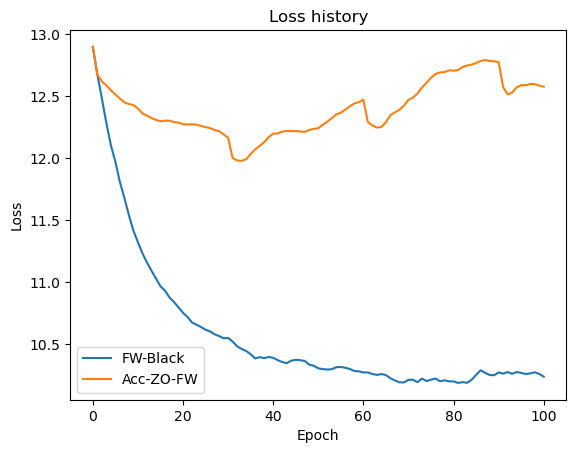

In [23]:
loss_ACC = np.genfromtxt("ACCZOFW.csv", delimiter=",")
loss_ZOFW = np.genfromtxt("FWBLACK.csv", delimiter=",")
plt.plot(loss_ZOFW, label= 'FW-Black')
plt.plot(loss_ACC, label= 'Acc-ZO-FW')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss history")